# Crawl sales data
## 1.Generate Powershell script 

In [1]:
# Global Constants
import os
data_directory='./data_all'

csv_path='df_sales_all.csv'

if not os.path.exists(data_directory):
    os.makedirs(data_directory)

In [2]:
# Constants
carGuidePrice="" # example "10-15" 
corpType=""
energyType=""
base="https://price.auto.sina.com.cn/api/PaihangbangSales/getSubSalesByParams?size=30"

def generateCommand(year="2023",month="01",page="1"):
    url=f'\"{base}&page={page}&year={year}&month={month}&carGuidePrice={carGuidePrice}&serialJiBie=&corpType={corpType}&ranliaoXingshi={energyType}&serial_id=&need_detail=1\"'

    fileName=f'{year}-{month}_{page}.json'
    command=f'curl {url} -o {data_directory}/{fileName}'
    return command

In [3]:
script=f'{data_directory}/getJSON.ps1'
with open(script,"w") as f:
    for year in ["2020","2021","2022","2023"]:
        for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
            for i in range(1,30):
                print(generateCommand(year,month,page=i),file=f)             

Regenerate unsuccessful requests commands

In [4]:
successJson=os.listdir(data_directory)
script=f'{data_directory}/reGetJSON.ps1'
with open(script,"w") as f:
    for year in ["2020","2021","2022","2023"]:
        for month in ["01","02","03","04","05","06","07","08","09","10","11","12"]:
            for page in range(1,30):
                fileName=f'{year}-{month}_{page}.json'
                if not fileName in successJson:
                    print(generateCommand(year,month,page=page),file=f)   

## 2.Crawl Data

In [5]:
script

'./data_all/reGetJSON.ps1'

In [6]:
if 0:# /1 to scrawl
    !powershell -ExecutionPolicy Bypass -File $script

## 3.Extract Data

In [7]:
import json
import pandas as pd

def extractData(filepath,df):
    with open(filepath,'r',encoding="utf8") as file:
        file_data=json.load(file)
        date = filepath.split('/')[-1].split('.')[0].split('_')[0]

        for i in range(len(file_data['data']['list'])):
            sub_brand_id=file_data['data']['list'][i]['sub_brand_id']
            sales_volume=file_data['data']['list'][i]['sales_volume']
            
            if  not sub_brand_id in df.index.values:
                serialZhName=file_data['data']['list'][i]['serial_info']['serialZhName']
                df.loc[sub_brand_id, 'serialZhName']=serialZhName
                df.loc[sub_brand_id, 'url']=f'https://db.auto.sina.com.cn/{sub_brand_id}'
            df.loc[sub_brand_id, date] = sales_volume
                

In [8]:
df_sales = pd.DataFrame(index=pd.Index([], name='sub_brand_id'))
for filename in os.listdir(data_directory):
    if filename.endswith('.json'):
        filepath = f'{data_directory}/{filename}'
        extractData(filepath,df_sales)

## 4.Postprocess
- fill null cell with 0

In [9]:
df_sales=df_sales.fillna(0)

In [10]:
df_sales.to_csv(csv_path)

## 5.Plot


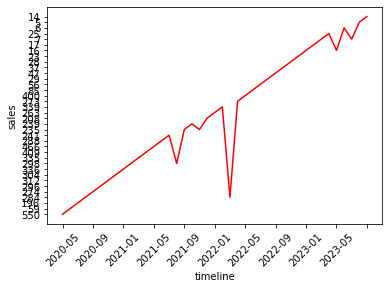

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.xlabel('timeline')
plt.ylabel('sales')

skipped_col_indices=['sub_brand_id','serialZhName','url']
x=[x for x in df_sales.columns if x not in skipped_col_indices]

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(4)) 
ax.xaxis.set_major_formatter(ticker.FixedFormatter(x[0::4])) 
plt.xticks(rotation=45)

row_index=61

y = df_sales.iloc[row_index, ~df_sales.columns.isin(skipped_col_indices)].values
# plt.title(df_sales.loc[row_index, 'serialZhName'])
plt.plot(x,y,color='r')
plt.show()